# On Analyzing Real World Time Series for Forecasting Stock Data
- Reference: real_world_investigation-base.ipynb

In [30]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from collections import namedtuple
from time_series import TimeSeriesFactory, UnivariateTimeSeries
from data_loader import build_stock_uts
from ts_models import Model, AR

from sklearn.metrics import mean_squared_error, max_error, mean_absolute_error, mean_absolute_percentage_error


## Stock Data Analysis

1. Load Raw Data
2. Plot Raw Data
3. Check Stationarity of Raw Data
4. Get Returns Data
5. Plot Returns Data
6. Check Stationarity of Returns Data
7. Split Data

### Load Raw Data

In [31]:
# Only grab stocks whose data is available for the entire time period
start_date, end_date = "2013-01-01", "2023-08-08"
Stock = namedtuple("Stock", ["symbol", "name"])
stocks = [
    ("^GSPC", "S&P 500"),
    ("AAPL", "Apple"),
    ("INTC", "Intel"),
    ("AMZN", "Amazon"),
    ("TSLA", "Tesla"),
    ("GOOGL", "Google")
]
stocks = [Stock(*s) for s in stocks]
stocks = {s.symbol: build_stock_uts(s.symbol, s.name, start_date=start_date, end_date=end_date) for s in stocks}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [32]:
values_cols = list(stocks.keys())
stock_mvts = TimeSeriesFactory.create_time_series(
    time_col="date",
    time_values=stocks[values_cols[0]].data.index,
    values_cols=values_cols,
    values=[stock.get_series() for stock in stocks.values()]
)

In [33]:
type(stocks['AAPL']), stocks['AAPL']

(time_series.UnivariateTimeSeries, UnivariateTimeSeries(Open))

How to call the created object
- stocks['AAPL'] is our `object`
- `object` `.method`
- NOTE: Do NOT need `()` when calling methods with `@property`

In [34]:
aapl_series = stocks['AAPL'].get_series()
aapl_series

array([ 19.77928543,  19.56714249,  19.17749977, ..., 191.57000732,
       185.52000427, 182.13000488])

In [35]:
aapl_df = stocks['AAPL'].get_as_df()
aapl_df

Open
Date                  
2013-01-02   19.779285
2013-01-03   19.567142
2013-01-04   19.177500
2013-01-07   18.642857
2013-01-08   18.900356
...                ...
2023-08-01  196.240005
2023-08-02  195.039993
2023-08-03  191.570007
2023-08-04  185.520004
2023-08-07  182.130005

[2667 rows x 1 columns]

### Plot Raw Data

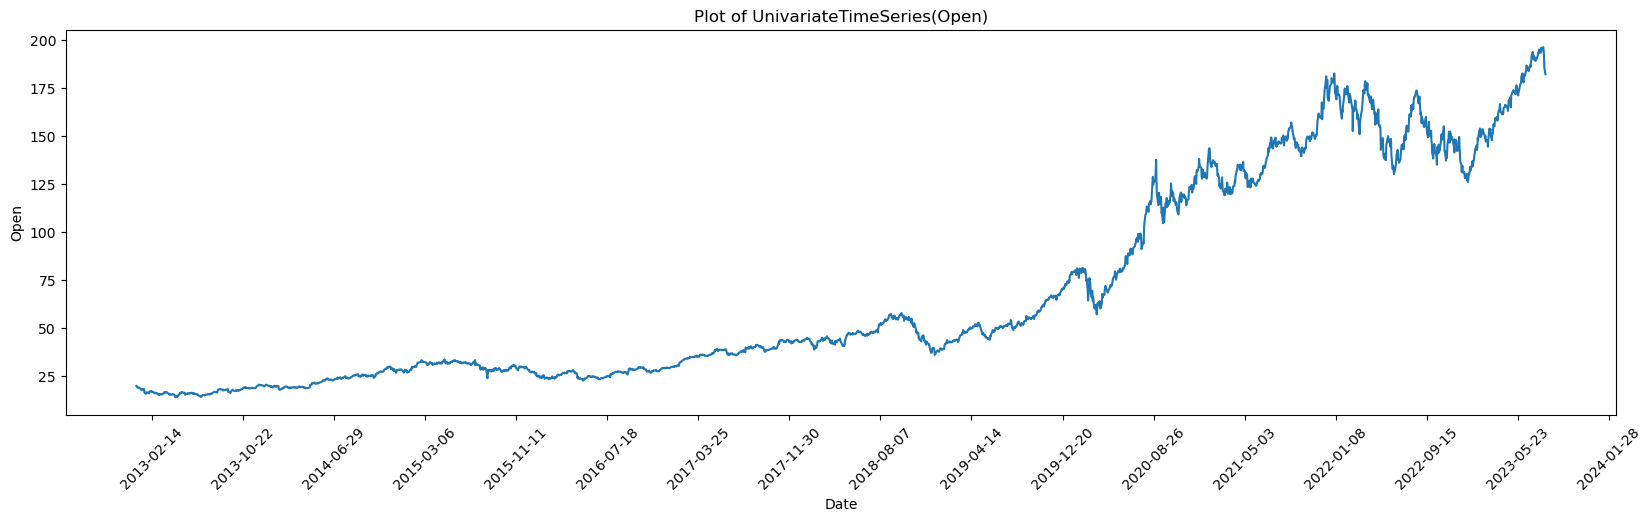

In [36]:
stocks['AAPL'].plot(tick_skip=250)

### Check Stationarity of Raw Data

In [37]:
stocks['AAPL'].stationarity_test(aapl_df)

Series is non-stationary as 0.9862528388956524 > 0.05


- With financial data, we expect it to be non-stationary. Verify this non-stationary with plotting the Autocorrelation.
- Below, there seems to be a high ACor, which means there's NOT such a difference between our 1st observation and kth lagged observation
    - What to do with this?  We must take the `returns`.

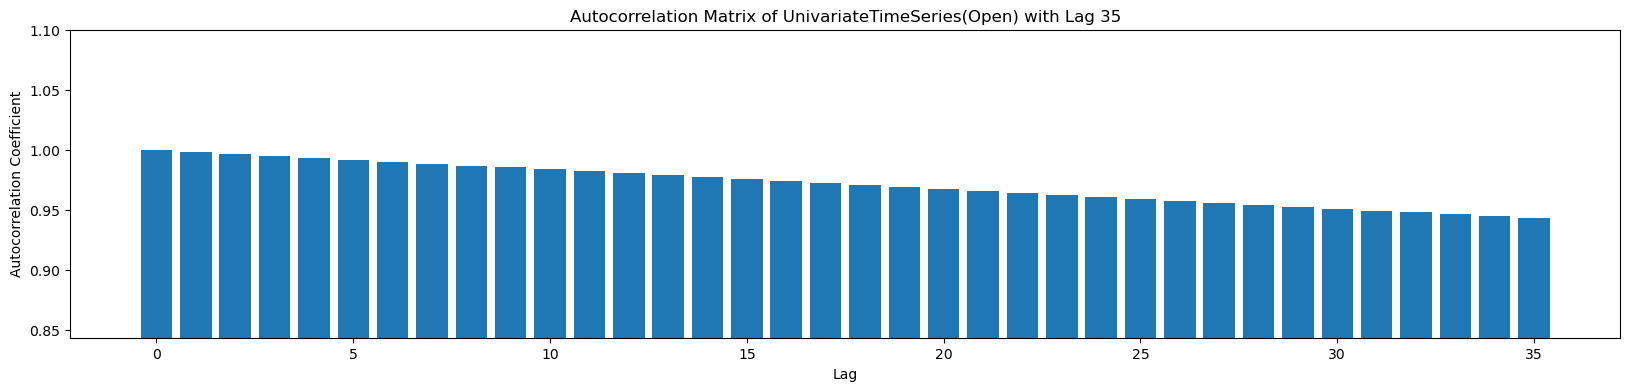

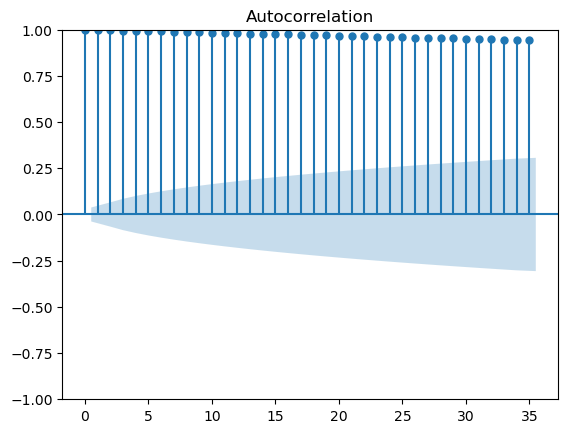

In [38]:
stocks['AAPL'].plot_autocorrelation(35)

### Get Returns Data

- Forecast returns
- Why: To have more stationarity compared to the prices `Open` which is non-stationary
- Calculate with the `percent change` between $ z_{t-1} $ and $ z_t $
    - If `percent change` < 0, then stock price is going down, hence a **loss** from $ z_{t-1} \rightarrow z_t $
    - If `percent change` > 0, then stock price is going up, hence a **gain** from $ z_{t-1} \rightarrow z_t $
    - If `percent change` = 0, then stock price is constant, hence a **no loss nor no gain** from $ z_{t-1} \rightarrow z_t $
- NOTE: Shift the date by 1 because we don't have anything to subtract the 0th date by.

In [39]:
aapl_returns = stocks['AAPL'].data_augment_for_returns()
aapl_returns

UnivariateTimeSeries(Returns)

In [40]:
aapl_returns_df = aapl_returns.get_as_df()
aapl_returns_df

Returns
Date                
2013-01-03 -0.010726
2013-01-04 -0.019913
2013-01-07 -0.027879
2013-01-08  0.013812
2013-01-09 -0.012679
...              ...
2023-08-01  0.000918
2023-08-02 -0.006115
2023-08-03 -0.017791
2023-08-04 -0.031581
2023-08-07 -0.018273

[2666 rows x 1 columns]

### Plot Returns Data

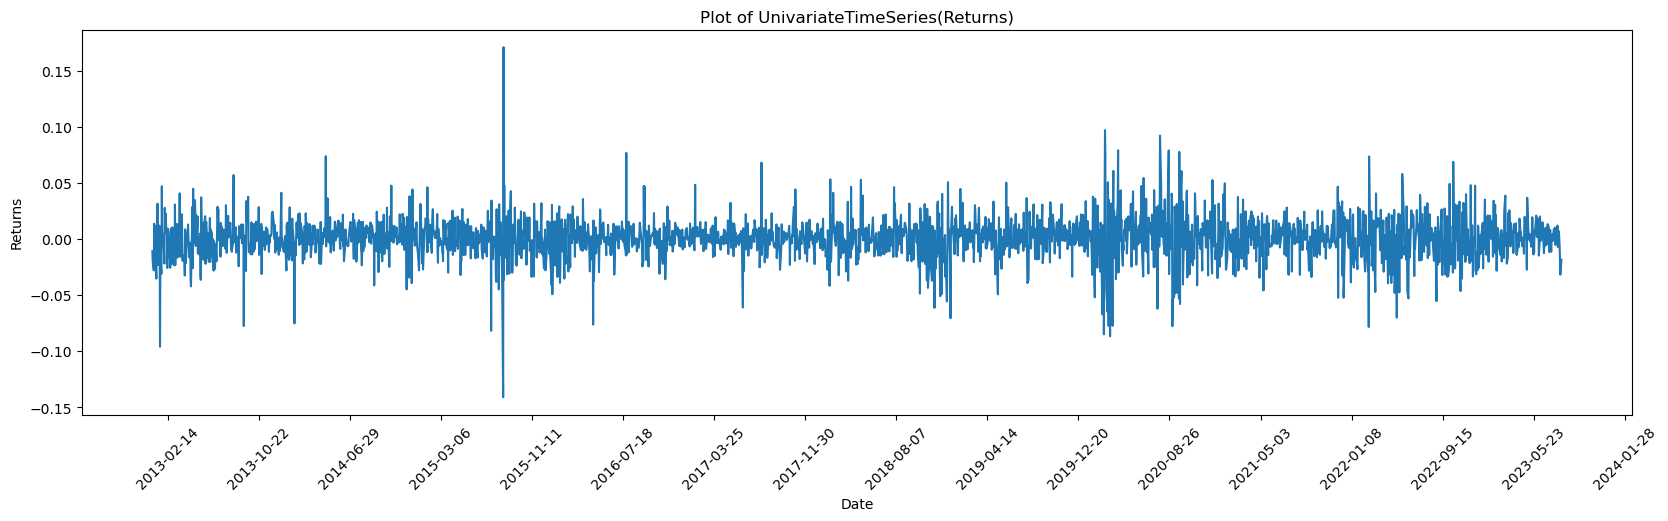

In [41]:
aapl_returns.plot(tick_skip=250)

### Check Stationarity of Return Data

In [42]:
aapl_returns.stationarity_test(aapl_returns_df)

Series is stationary as 0.0 < 0.05


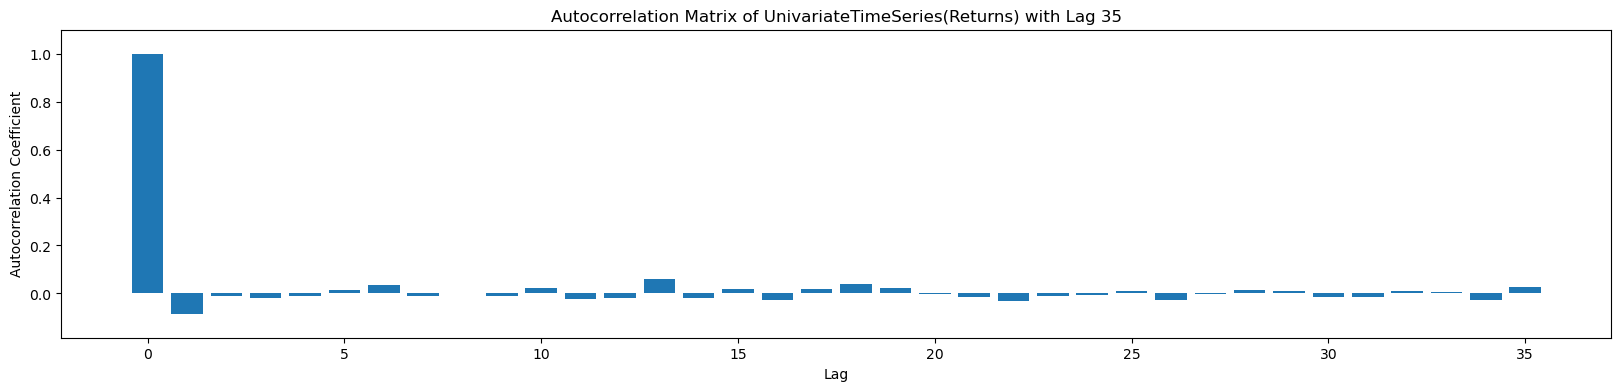

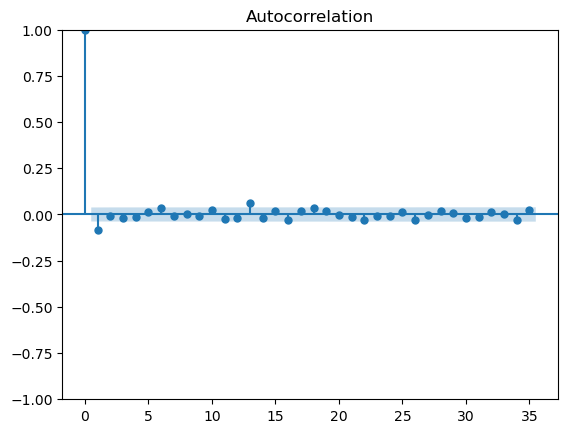

In [43]:
aapl_returns.plot_autocorrelation(35)

### Split Data

In [44]:
N = len(aapl_returns)
N

2666

In [45]:
train, validation, test = aapl_returns.get_train_validation_test_split(0.9, 0.0)

0 2399
2399 2399
2399 2666


In [46]:
train

UnivariateTimeSeries(UnivariateTimeSeries(Returns)[0:2399])

In [47]:
train.get_as_df()

UnivariateTimeSeries(Returns)[0:2399]
Date                                             
2013-01-03                              -0.010726
2013-01-04                              -0.019913
2013-01-07                              -0.027879
2013-01-08                               0.013812
2013-01-09                              -0.012679
...                                           ...
2022-07-08                               0.013748
2022-07-11                               0.002823
2022-07-12                               0.000618
2022-07-13                              -0.019004
2022-07-14                               0.007623

[2399 rows x 1 columns]

In [48]:
validation

UnivariateTimeSeries(UnivariateTimeSeries(Returns)[2399:2399])

In [49]:
validation.get_as_df()

Empty DataFrame
Columns: [UnivariateTimeSeries(Returns)[2399:2399]]
Index: []

In [50]:
test

UnivariateTimeSeries(UnivariateTimeSeries(Returns)[2399:2666])

In [51]:
test.get_as_df()

UnivariateTimeSeries(Returns)[2399:2666]
Date                                                
2022-07-15                                  0.039561
2022-07-18                                  0.006409
2022-07-19                                 -0.018708
2022-07-20                                  0.021633
2022-07-21                                  0.022366
...                                              ...
2023-08-01                                  0.000918
2023-08-02                                 -0.006115
2023-08-03                                 -0.017791
2023-08-04                                 -0.031581
2023-08-07                                 -0.018273

[267 rows x 1 columns]

In [52]:
ar_model_class = AR()
trained_ar_model = ar_model_class.train_ar_model(train.get_series(), 2)

In [53]:
historical_data = len(train.get_series())
historical_data

2399

In [54]:
tomorrow = len(aapl_returns) - 1
tomorrow

2665

In [60]:
prediction = trained_ar_model.predict(start=historical_data, end=tomorrow, dynamic=False)
len(prediction)

267

In [68]:
len(prediction)

267

0.0003144814939360618
0.06802731251270229
0.013556741784484183
1.2333778511256062


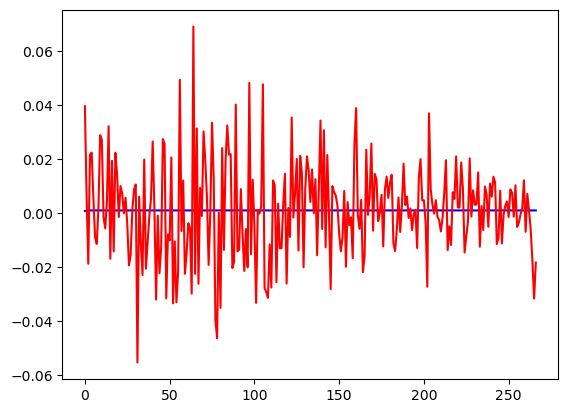

In [69]:
mse = mean_squared_error(test.get_series(), prediction)
print(mse)

print(max_error(test.get_series(), prediction))
print(mean_absolute_error(test.get_series(), prediction))
print(mean_absolute_percentage_error(test.get_series(), prediction))

plt.plot(prediction, color='blue')
plt.plot(test.get_series(), color='red')
plt.show()